# Wind Downscaling


In [1]:
import os
from datetime import date, datetime
from pathlib import Path
from dotenv import load_dotenv
from data.data_generator import BatchGenerator, NaiveDecoder, LocalFileProvider, S3FileProvider, NoiseGenerator
from gan import train, metrics
from gan.models import make_discriminator
load_dotenv()
import numpy as np
import tensorflow as tf
import tensorflow.keras.callbacks as cb
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
import pandas as pd

Num GPUs Available: 0


## Set configuration

In [2]:
DATA_ROOT = Path('./data')
ERA5_DATA_FOLDER = DATA_ROOT / 'ERA5'
COSMO1_DATA_FOLDER = DATA_ROOT / 'COSMO1'
DEM_DATA_FILE = DATA_ROOT / 'dem/Switzerland-90m-DEM.tif'
PROCESSED_DATA_FOLDER = DATA_ROOT / 'img_prediction_files'

DATA_ROOT.mkdir(parents=True, exist_ok=True)
ERA5_DATA_FOLDER.mkdir(exist_ok=True)
COSMO1_DATA_FOLDER.mkdir(exist_ok=True)
DEM_DATA_FILE.parent.mkdir(exist_ok=True)
PROCESSED_DATA_FOLDER.mkdir(exist_ok=True)
cosmoblurred = True
run_id=datetime.today().strftime('%Y%m%d_%H%M')
data_provider = 'local'

In [3]:
# Start and end date for the data - should be in the 2016-2020 range
START_DATE = date(2017,1,1)
END_DATE = date(2017,12,31)
NUM_DAYS = (END_DATE-START_DATE).days + 1
# Number of consecutive images to form a sequence
SEQUENCE_LENGTH = 3
# Size of the high resolution image to be produced
IMG_SIZE = 64
# Number of sequences per batch
BATCH_SIZE = 8

In [4]:
TOPO_PREDICTORS = ['tpi_500', 'slope', 'aspect']
HOMEMADE_PREDICTORS = ['e_plus', 'e_minus', 'w_speed', 'w_angle']
ERA5_PREDICTORS_SURFACE = ['u10', 'v10', 'blh', 'fsr', 'sp', 'sshf']
ERA5_PREDICTORS_Z500 = ['z']
if cosmoblurred:
    ALL_INPUTS = ['U_10M', 'V_10M'] + HOMEMADE_PREDICTORS + TOPO_PREDICTORS
    input_pattern = 'x_cosmo_{date}.nc'
    run_id = f'{run_id}_cosmo_blurred'
else:
    ALL_INPUTS = ERA5_PREDICTORS_Z500 + ERA5_PREDICTORS_SURFACE + TOPO_PREDICTORS + HOMEMADE_PREDICTORS
    input_pattern = 'x_{date}.nc'
ALL_INPUTS = ['U_10M', 'V_10M']
ALL_OUTPUTS = ['U_10M', 'V_10M']
BATCH_WORKERS = os.cpu_count()
if data_provider == 'local':
    input_provider = LocalFileProvider(PROCESSED_DATA_FOLDER, input_pattern)
    output_provider = LocalFileProvider(PROCESSED_DATA_FOLDER, 'y_{date}.nc')
elif data_provider == 's3':
    input_provider = S3FileProvider('wind-downscaling', 'img_prediction_files', pattern=input_pattern)
    output_provider = S3FileProvider('wind-downscaling', 'img_prediction_files', pattern='y_{date}.nc')
else:
    raise ValueError(f'Wrong value for data provider {data_provider}: please choose between s3 and local')
AVAIL_DATES = [pd.to_datetime(v) for v in
               set(input_provider.available_dates).intersection(output_provider.available_dates)]
START_DATE = min(AVAIL_DATES)
END_DATE = max(AVAIL_DATES)
batch_gen = BatchGenerator(input_provider, output_provider,
                                    decoder=NaiveDecoder(normalize=True),
                                    sequence_length=SEQUENCE_LENGTH,
                                    patch_length_pixel=IMG_SIZE, batch_size=BATCH_SIZE,
                                    input_variables=ALL_INPUTS,
                                    output_variables=ALL_OUTPUTS,
                                    start_date=START_DATE, end_date=END_DATE,
                                    num_workers=BATCH_WORKERS)
INPUT_CHANNELS = len(ALL_INPUTS)
OUT_CHANNELS = len(ALL_OUTPUTS)


In [ ]:
inputs = []
outputs = []
with batch_gen as batch:
    for b in range(NUM_DAYS):
        print(f'Creating batch {b+1}/{NUM_DAYS}')
        x, y = next(batch)
        inputs.append(x)
        outputs.append(y)
inputs = np.concatenate(inputs, axis=0)
outputs = np.concatenate(outputs, axis=0)

In [27]:
print(f"Inputs: {inputs.shape}")
print(f"Outputs: {outputs.shape}")
n_examples = inputs.shape[0]
noise = NoiseGenerator(inputs.shape)()[...,:2]
x = np.concatenate([inputs, noise], axis=0)
x = (x, np.concatenate([outputs, outputs], axis=0))
y = np.concatenate([np.ones(n_examples), -np.ones(n_examples)])
print(x[0].shape, x[1].shape, y.shape)

Inputs: (2920, 3, 64, 64, 2)
Outputs: (2920, 3, 64, 64, 2)
(5840, 3, 64, 64, 2) (5840, 3, 64, 64, 2) (5840,)


In [28]:
INPUT_CHANNELS = len(ALL_INPUTS)
OUT_CHANNELS = len(ALL_OUTPUTS)

In [29]:
discriminator = make_discriminator(low_res_size=IMG_SIZE, high_res_size=IMG_SIZE,
                               low_res_channels=INPUT_CHANNELS,
                               high_res_channels=OUT_CHANNELS,
                                        n_timesteps=SEQUENCE_LENGTH)
print(f"Generator: {discriminator.count_params():,} weights")

def loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

discriminator.compile(optimizer=train.discriminator_optimizer(),
                  metrics=['accuracy'],
                  loss=loss)

Generator: 2,123,081 weights


In [30]:
checkpoint_path_weights = Path('./checkpoints/discriminator') / run_id / 'weights-{epoch:02d}.ckpt'
checkpoint_path_weights.parent.mkdir(exist_ok=True, parents=True)
log_path = Path('./logs/discriminator') / run_id
if log_path.exists():
    log_path_str = str(log_path)
    !rm -rf {log_path_str}

In [31]:
%load_ext tensorboard
%tensorboard --logdir=$log_path

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [32]:
callbacks = [
        cb.TensorBoard(log_path, write_images=True, update_freq='batch'),
        cb.ProgbarLogger('steps'),
        cb.TerminateOnNaN(),
        cb.ModelCheckpoint(str(checkpoint_path_weights), save_best_only=False, period=10,
                           save_weights_only=True),
    ]

In [33]:
discriminator.fit(x=x, y=y, callbacks=callbacks, epochs=50)

Epoch 1/50
183/183 [==============================] - 245s 1s/step - loss: -168.8731 - accuracy: 0.3130
Epoch 2/50
183/183 [==============================] - 215s 1s/step - loss: -1023.5041 - accuracy: 0.4652
Epoch 3/50
183/183 [==============================] - 234s 1s/step - loss: -1853.2492 - accuracy: 0.1682
Epoch 4/50
183/183 [==============================] - 327s 2s/step - loss: -2554.4853 - accuracy: 0.5003
Epoch 5/50
183/183 [==============================] - 364s 2s/step - loss: -3650.2903 - accuracy: 0.4921
Epoch 6/50
183/183 [==============================] - 272s 1s/step - loss: -4072.0458 - accuracy: 0.0000e+00
Epoch 7/50
183/183 [==============================] - 381s 2s/step - loss: -3954.4956 - accuracy: 0.0000e+00
Epoch 8/50
183/183 [==============================] - 383s 2s/step - loss: -5028.4753 - accuracy: 0.0176
Epoch 9/50
183/183 [==============================] - 382s 2s/step - loss: -7204.7442 - accuracy: 0.5074
Epoch 10/50
183/183 [===========================

In [43]:
scores_true = discriminator([inputs, outputs])
scores_fake = discriminator([noise, outputs])

In [46]:
scores_true_np = scores_true.numpy()
scores_true_np = np.squeeze(scores_true_np)
scores_fake_np = scores_fake.numpy()
scores_fake_np = np.squeeze(scores_fake_np)

(array([3.49251045e-04, 9.80297503e-05, 1.60147538e-05, 4.85295570e-06,
        1.94118228e-06, 1.13235633e-06, 3.23530678e-07, 3.23530380e-07,
        1.61765190e-07, 3.23530380e-07]),
 array([10737.86 , 12854.915, 14971.969, 17089.023, 19206.078, 21323.133,
        23440.188, 25557.24 , 27674.295, 29791.35 , 31908.404],
       dtype=float32),
 <BarContainer object of 10 artists>)

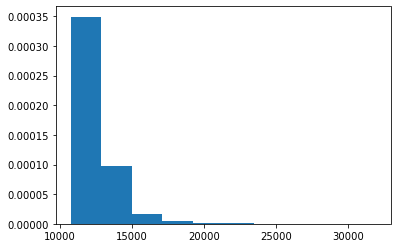

In [50]:
import matplotlib.pyplot as plt
plt.hist(scores_true_np, density=True)

(array([4.31059194e-08, 3.01742623e-07, 8.62118389e-08, 3.01742623e-07,
        1.42249534e-06, 4.09506235e-06, 9.69887002e-06, 2.44410563e-05,
        5.78914775e-05, 2.75877884e-05]),
 array([293729.62, 301674.38, 309619.1 , 317563.84, 325508.56, 333453.3 ,
        341398.06, 349342.78, 357287.53, 365232.25, 373177.  ],
       dtype=float32),
 <BarContainer object of 10 artists>)

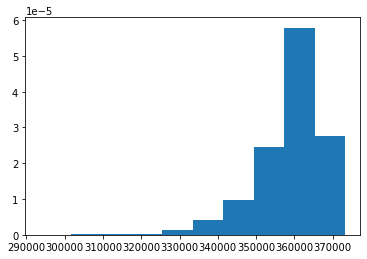

In [49]:
plt.hist(scores_fake_np, density=True)